In [235]:
import numpy as np
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

In [223]:
"""
Criação das coordenadas de cada ponto
"""

pontos = pd.DataFrame({'nome': range(1,13),
                   'longitude': [742562.864280,
                                 742800.532496,
                                 742543.114386,
                                 742628.139353,
                                 742701.448282,
                                 742796.515568,
                                 742526.711931,
                                 742609.058947,
                                 742699.439818,
                                 742519.012820,
                                 742692.075451,
                                 742791.829153],
                   'latitude': [6945542.356623,
                                6945541.687135,
                                6945461.348583,
                                6945459.005375,
                                6945453.984216,
                                6945451.306264,
                                6945287.616464,
                                6945282.595305,
                                6945346.866146,
                                6945225.688831,
                                6945227.027806,
                                6945224.349866]})

pontos.head()

,nome,longitude,latitude
0,1,742562.864280,6.945542e+06
1,2,742800.532496,6.945542e+06
2,3,742543.114386,6.945461e+06
3,4,742628.139353,6.945459e+06
4,5,742701.448282,6.945454e+06


In [224]:
"""
Criação dos polígonos
"""

land_use_data = {
    'Floresta': [1, 2, 6, 5, 4, 3, 1],
    'Solo Exposto': [3, 4, 8, 7, 3],
    'Café': [4, 5, 9, 8, 4],
    'Milho': [7, 8, 9, 11, 10, 7],
    'Soja': [5, 6, 12, 11, 9, 5]
}

geometry = [Point(x, y) for x, y in zip(pontos['longitude'], pontos['latitude'])]
pontos_gdf = gpd.GeoDataFrame(pontos, geometry=geometry, crs='EPSG:4674')

pontos_gdf.head()

{'Floresta': [1, 2, 6, 5, 4, 3, 1],
 'Solo Exposto': [3, 4, 8, 7, 3],
 'Café': [4, 5, 9, 8, 4],
 'Milho': [7, 8, 9, 11, 10, 7],
 'Soja': [5, 6, 12, 11, 9, 5]}

In [226]:
"""
União das coordenadas dos pontos com os pontos de cada polígono
"""

polygons = []
for land_use, points in land_use_data.items():

    land_use_points = []
    for point in points:
      land_use_points.append(pontos_gdf[pontos_gdf['nome'] == point])
    land_use_points = pd.concat(land_use_points)

    coords = [(point.x, point.y) for point in land_use_points['geometry']]
    polygon = Polygon(coords)
    polygons.append((land_use, polygon))

gdf = gpd.GeoDataFrame(polygons, columns=['tipo_de_uso', 'geometry'], crs='EPSG:4674')

gdf

,tipo_de_uso,geometry
0,Floresta,"POLYGON ((742562.86428 6945542.35662, 742800.5..."
1,Solo Exposto,"POLYGON ((742543.11439 6945461.34858, 742628.1..."
2,Café,"POLYGON ((742628.13935 6945459.00537, 742701.4..."
3,Milho,"POLYGON ((742526.71193 6945287.61646, 742609.0..."
4,Soja,"POLYGON ((742701.44828 6945453.98422, 742796.5..."


In [268]:
"""
Cálculo da área de cada um dos polígonos através do método de Gauss, seguida da porcentagem representada por cada tipo de solo
"""
areas = pd.DataFrame()
for i, row in gdf.iterrows():
  X, Y = list(row.geometry.exterior.xy[1]), list(row.geometry.exterior.xy[0])

  Ma, Mb = 0, 0
  for i in range(len(X)):
      if i != len(X) - 1:
          Ma += X[i] * Y[i+1]
          Mb += Y[i] * X[i+1]
      else:
          Ma += X[i] * Y[0]
          Mb += X[0] * Y[i]

  area = 0.5 * abs(Ma - Mb)
  areas = pd.concat([areas, pd.DataFrame({'tipo_de_uso': [row['tipo_de_uso']],
                                          'area': [area]})])

areas = areas.reset_index(drop=True)
areas['pct'] = areas['area']/areas['area'].sum()
gdf = pd.merge(gdf,areas,'left','tipo_de_uso')

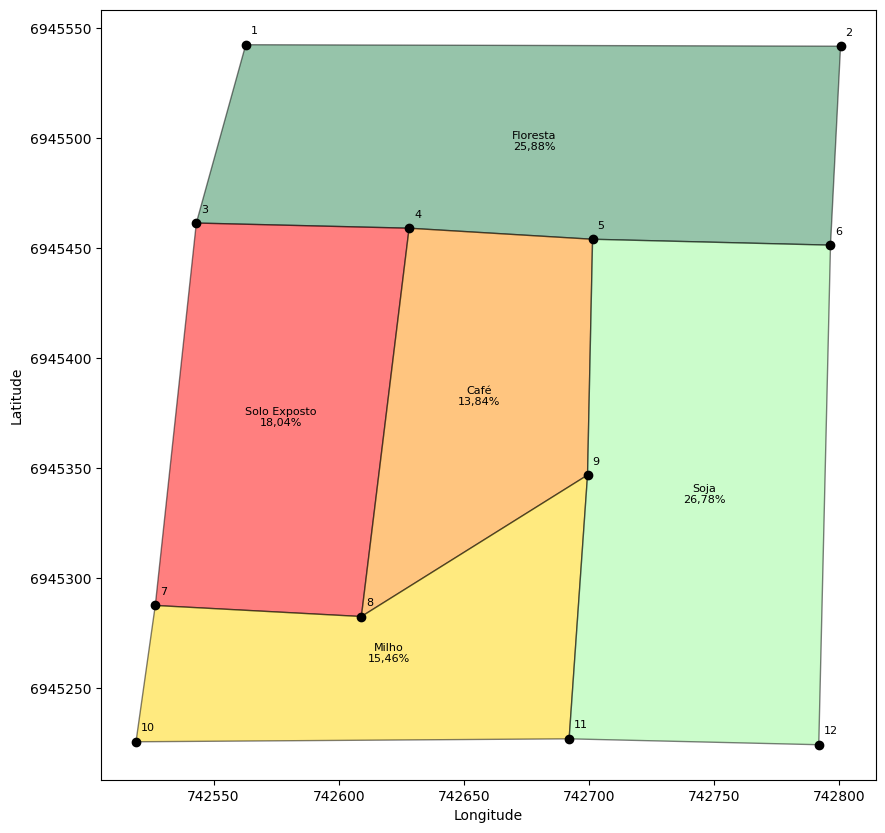

In [285]:
"""
Mapa com os polígonos e suas porcentagens da área total
"""

tipo_de_uso_colors = {
    'Floresta': 'seagreen',
    'Solo Exposto': 'red',
    'Café': 'darkorange',
    'Milho': 'gold',
    'Soja': 'palegreen'
}

fig, ax = plt.subplots(figsize=(10, 10))
for tipo_de_uso in gdf['tipo_de_uso'].unique():
    color = tipo_de_uso_colors[tipo_de_uso]
    for index, row in gdf[gdf['tipo_de_uso'] == tipo_de_uso].iterrows():
        polygon = row['geometry']
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5, edgecolor='black')

        ax.annotate(tipo_de_uso, (polygon.centroid.x, polygon.centroid.y+2.5), color='black', fontsize=8, ha='center', va='center')

        pct_formatted = (str(round(row['pct']*100,2)) + '%').replace('.',',')
        ax.annotate(pct_formatted, (polygon.centroid.x, polygon.centroid.y-2.5), color='black', fontsize=8, ha='center', va='center')

for index, row in pontos_gdf.iterrows():
    ax.scatter(row['longitude'], row['latitude'], color='black')
    ax.annotate(row['nome'], (row['longitude']+2, row['latitude']+4), color='black', fontsize=8, ha='left', va='bottom')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()